### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

### Load data

In [3]:
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')
print('Test samples:', len(submission))

# Preprocecss data
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(test.head())

Test samples: 14792


,image
0,002f507.jpg
1,0035ae9.jpg
2,0038327.jpg
3,004f759.jpg
4,005ba08.jpg


# Model parameters

In [4]:
BACKBONE = 'efficientnetb3'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.82, 0.94, 0.84, 0.79]
best_tresholds_seg = [0.35, 0.4, 0.4, 0.6]
best_masks_seg = [17500, 20000, 17500, 12500]

model_name = '36-[seg]59-UNet EfficientNetB3[class]19-EfficientNetB0.h5'
classification_model_path = '../input/cloud-seg-modelstoevaluate/19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_path = '../input/cloud-seg-modelstoevaluate/59-unet_efficientnetb3_320x480.h5'
test_images_path = '../input/cloud-images-resized-320x480/test_images320x480/test_images/'

In [5]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [6]:
classification_model = load_model(classification_model_path)
segmentation_model = load_model(segmentation_model_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

# Classification data generator

In [7]:
test_datagen=ImageDataGenerator(rescale=1./255.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Apply segmentation model to test set

In [8]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###

        ### Post procecssing CLEAN
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=20000)
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_clean'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test = pd.concat(test_df)

## Apply classifcation model to test set

In [9]:
test_class_preds = classification_model.predict_generator(classification_test_generator)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)
  
X_test['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test['EncodedPixels_post_class'] = X_test.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask'] == 0 else np.nan, axis=1)

### Number of masks removed

In [10]:
print('Masks removed: %s' % len(X_test[(~X_test['EncodedPixels'].isnull()) & (X_test['empty_mask'] == 1)]))

Masks removed: 1308


# Using TTA Wrapper

In [11]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean')
segmentation_model_tta.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, None, None, 3)        0         
_________________________________________________________________
repeat_1 (Repeat)            (4, None, None, 3)        0         
_________________________________________________________________
tta_1 (TTA)                  (4, None, None, 3)        0         
_________________________________________________________________
model_1 (Model)              multiple                  17868268  
_________________________________________________________________
tta_2 (TTA)                  (4, None, None, 4)        0         
_________________________________________________________________
merge_1 (Merge)              (1, None, None, 4)        0         
Total params: 17,868,268
Trainable params: 17,778,988
Non-trainable params: 89,280
__________________________________________

### Apply segmentation model to test set (TTA)

In [12]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=20000)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

### Inspecting some of the test set predictions

### Without post-process

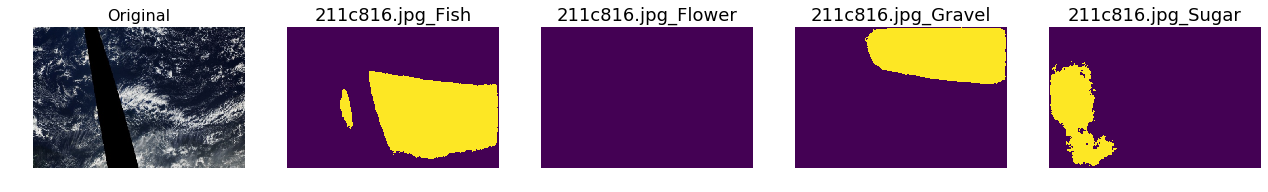

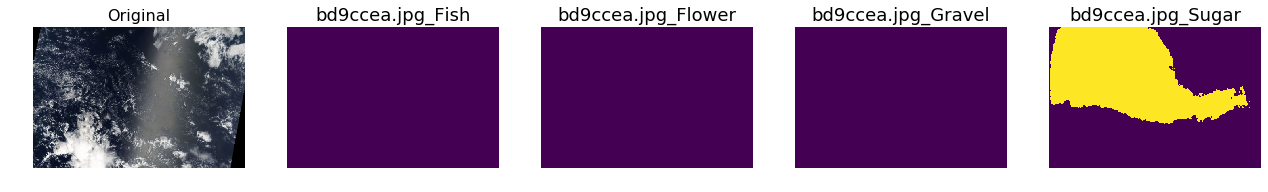

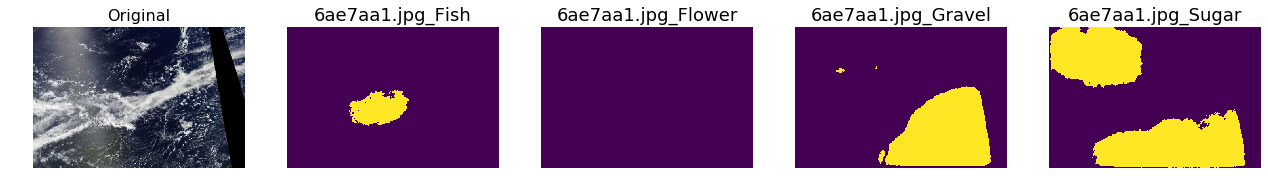

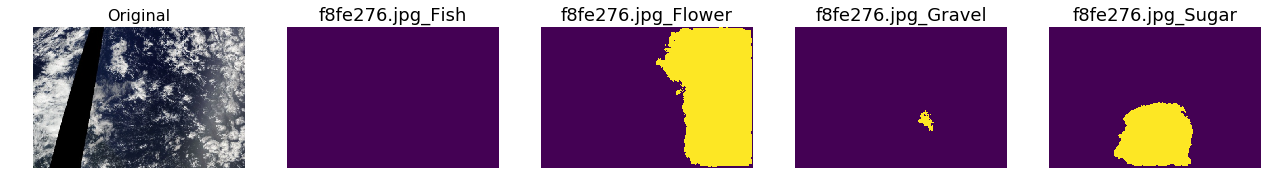

In [13]:
images_to_inspect_test =  np.random.choice(X_test['image'].unique(), 4, replace=False)
inspect_predictions(X_test, images_to_inspect_test, test_images_path)

### With post-process

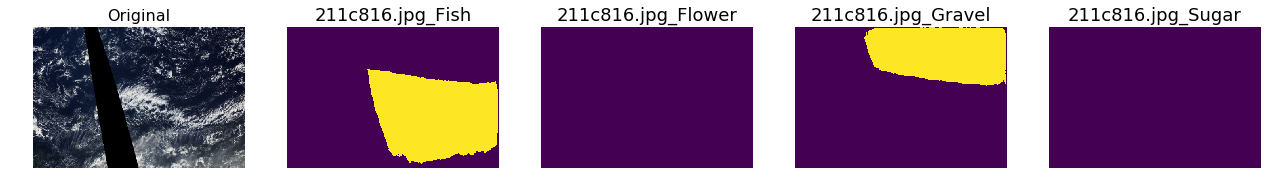

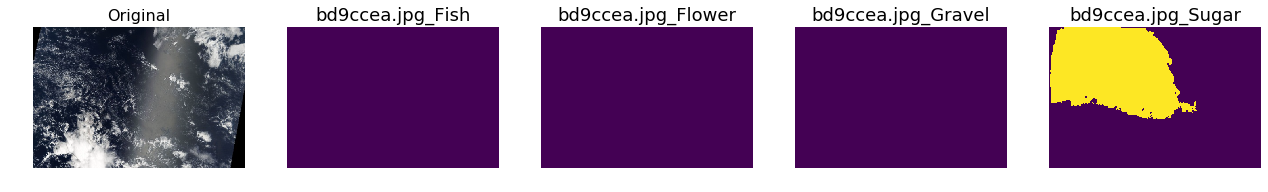

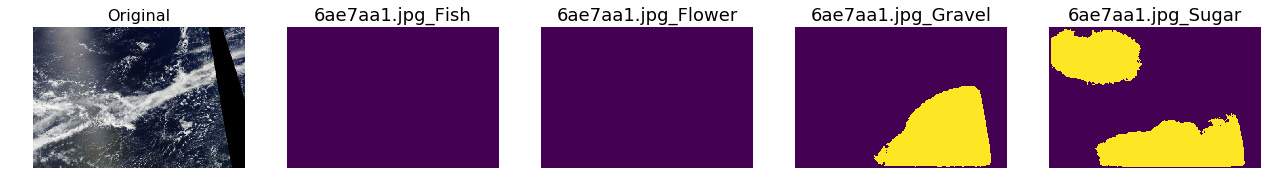

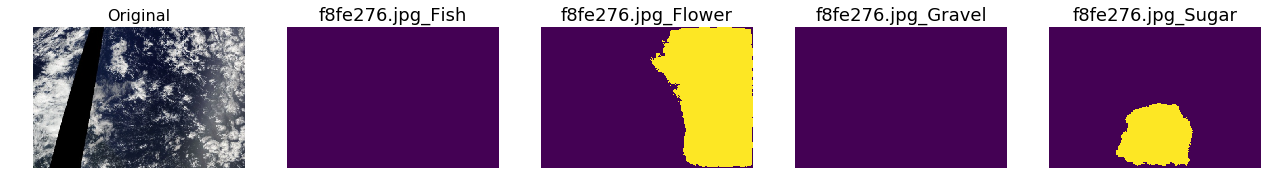

In [14]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### With post-process clean

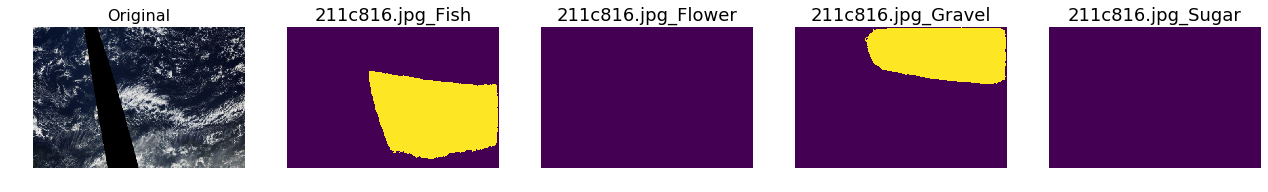

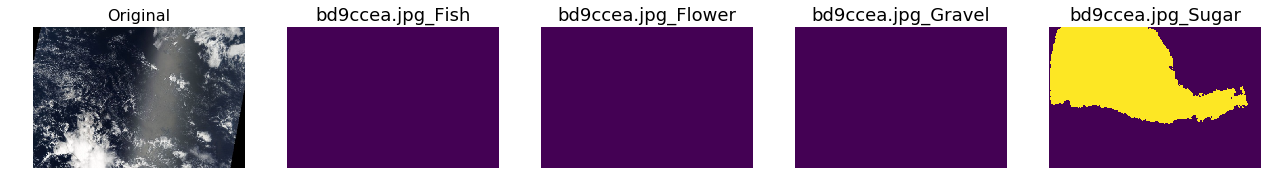

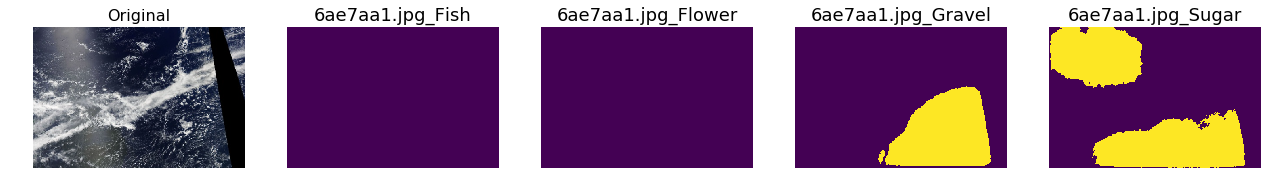

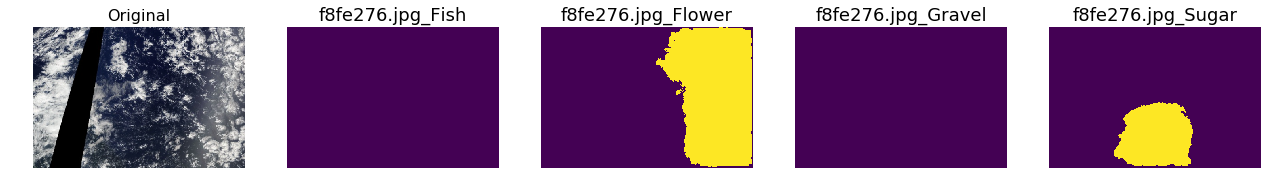

In [15]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_clean')

### With post-process and mask classification

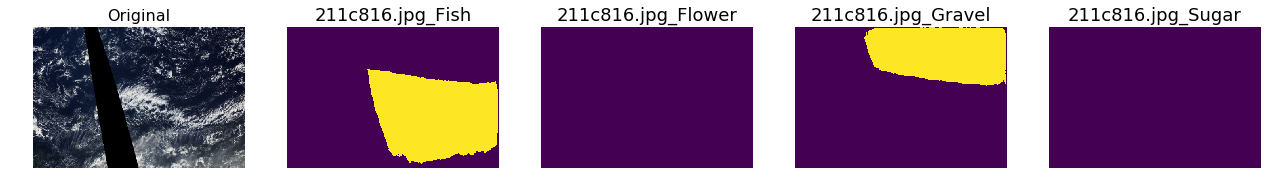

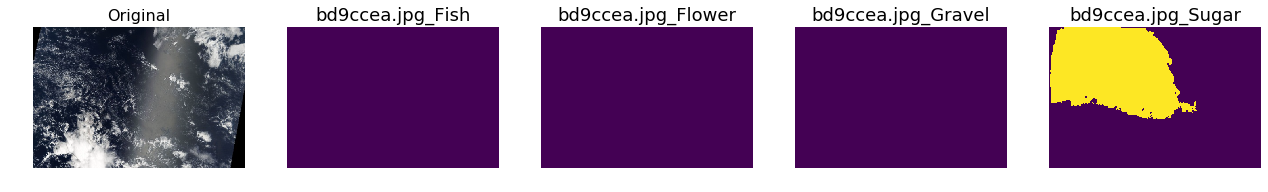

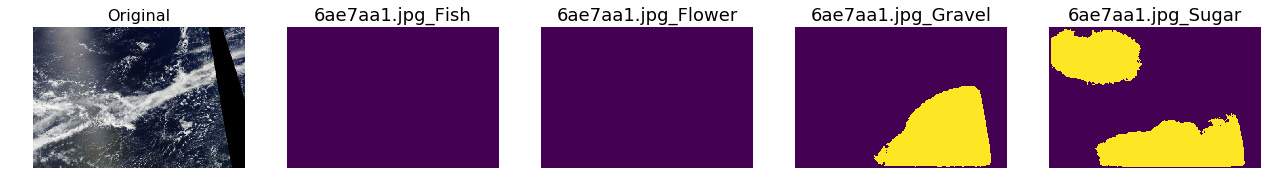

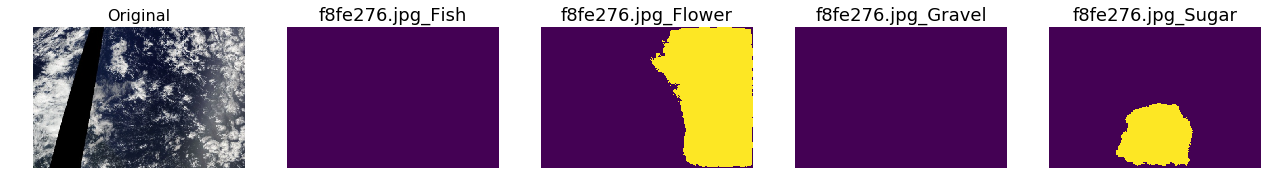

In [16]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_class')

### Without post-process and TTA

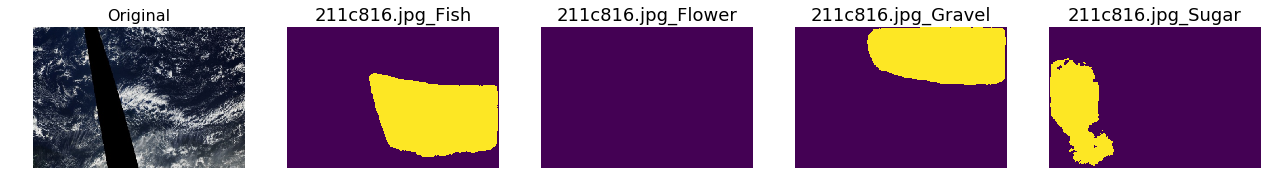

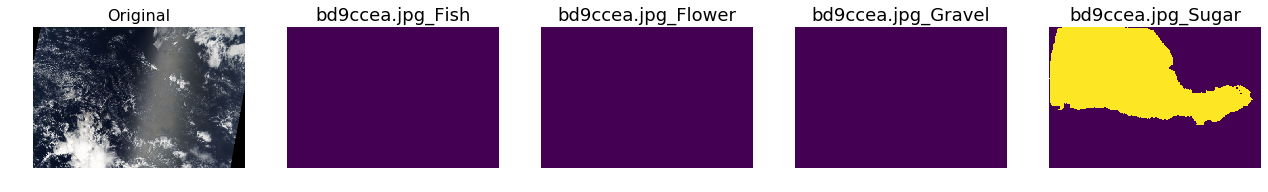

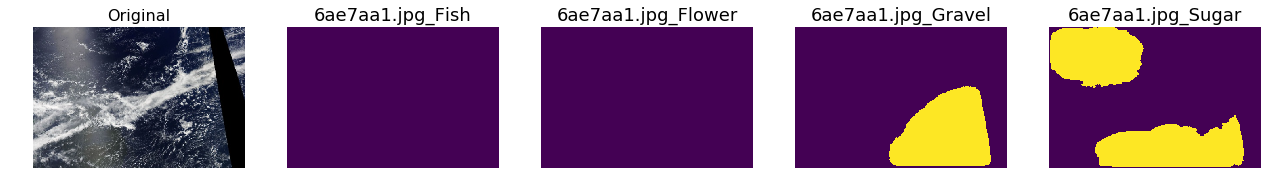

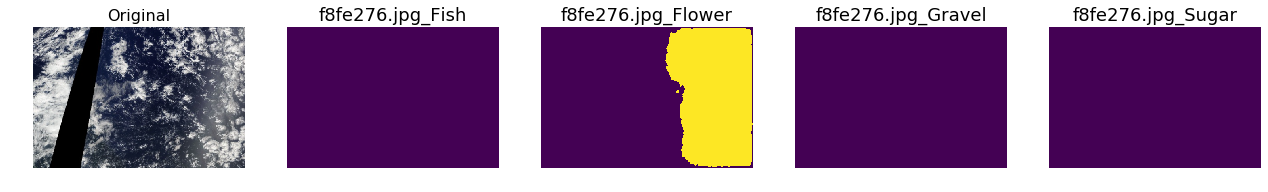

In [17]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

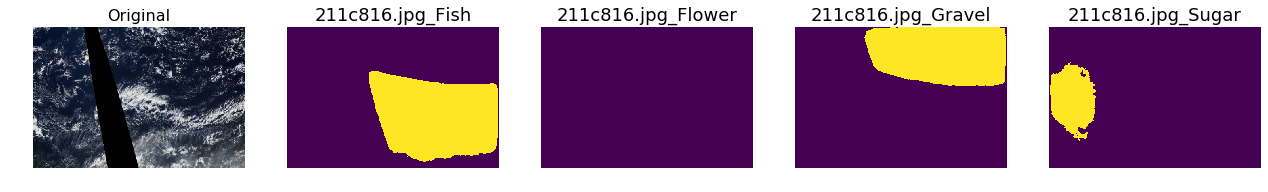

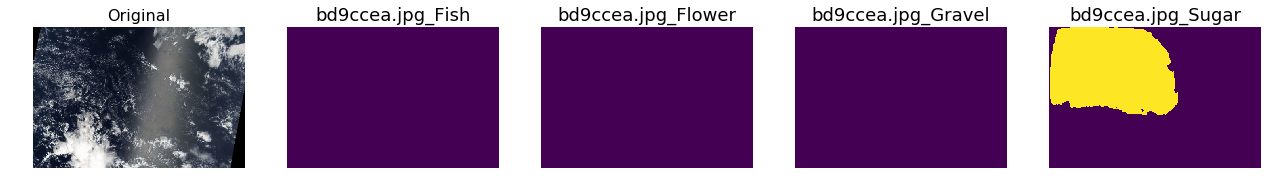

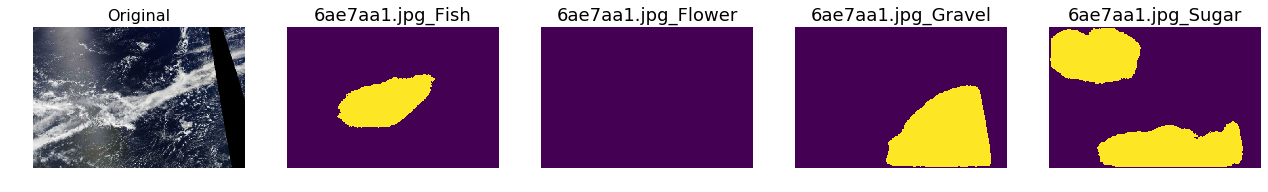

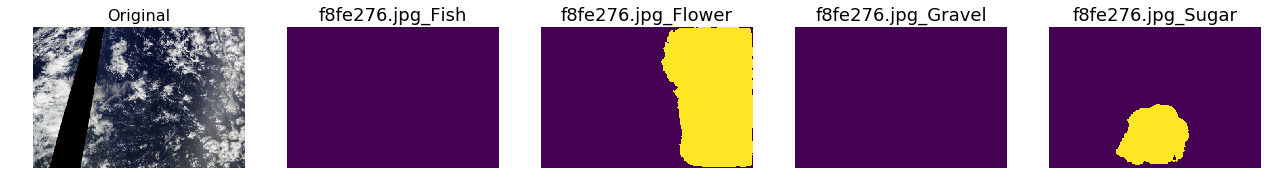

In [18]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Regular submission

In [19]:
submission_df = X_test[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1346 3 1444 1 1456 31 1489 15 1508 53 1563 9 1...
3,002f507.jpg_Sugar,2060 1 11384 1 11739 1 12087 3 12437 3 12787 4...
4,0035ae9.jpg_Fish,


### Submission with post processing

In [20]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1110 9 1128 1 1132 3 1143 3 1160 3 1173 8 1184...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing clean

In [21]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post_clean']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post_clean.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1346 3 1444 1 1456 31 1489 15 1508 53 1563 9 1...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and mask classification

In [22]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post_class']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post_class.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,1110 9 1128 1 1132 3 1143 3 1160 3 1173 8 1184...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission without post processing and TTA

In [23]:
submission_df_post_class = X_test_tta[['Image_Label' ,'EncodedPixels_tta']]
submission_df_post_class.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post_class.to_csv('submission_tta.csv', index=False)
display(submission_df_post_class.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1113 9 1136 1 1143 2 1166 1 1175 2 1334 1 1346...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and TTA

In [24]:
submission_df_post_class = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df_post_class.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post_class.to_csv('submission_post_tta.csv', index=False)
display(submission_df_post_class.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1088 1 1093 185 1315 41 1359 5 1420 211 1642 8...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
